In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import os


In [2]:
keras = tf.keras
layers = tf.keras.layers

## 数据读取部分

#### 训练集

In [3]:
# 指定训练和验证数据集的路径
train_image_path = glob.glob('C:/Users/B407/Desktop/TXRCODE/IEEESensor2/train/*/*.jpg')

In [4]:
train_image_path[:5]

['C:/Users/B407/Desktop/TXRCODE/IEEESensor2/train\\0wuquexian\\0_0_0_0_1.jpg',
 'C:/Users/B407/Desktop/TXRCODE/IEEESensor2/train\\0wuquexian\\1_1_1_10_1.jpg',
 'C:/Users/B407/Desktop/TXRCODE/IEEESensor2/train\\0wuquexian\\1_1_1_11_1.jpg',
 'C:/Users/B407/Desktop/TXRCODE/IEEESensor2/train\\0wuquexian\\1_1_1_12_1.jpg',
 'C:/Users/B407/Desktop/TXRCODE/IEEESensor2/train\\0wuquexian\\1_1_1_13_1.jpg']

In [5]:
train_image_path[0].split('\\')[1][0]

'0'

In [6]:
train_image_label = [int(p.split('\\')[1][0])  for p in train_image_path ]

In [7]:
train_image_label[537:540]

[0, 0, 0]

In [8]:
# 训练集图片读取
def load_train_image(path,label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image,channels=1)    # 解码图片
    image = tf.image.grayscale_to_rgb(image)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image,0.1)
    image = tf.cast(image,tf.float32)   
    image = image/255                                 # 先转换成float类型，再进行归一化处理
    label = tf.reshape(label,[1])                     # [0,0,1]——>[[0],[0],[1]]
    return image,label

# 测试集图片读取
def load_test_image(path,label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image,channels=1)    # 解码图片
    image = tf.image.grayscale_to_rgb(image)
    image = tf.cast(image,tf.float32)   
    image = image/255                                 # 先转换成float类型，再进行归一化处理
    label = tf.reshape(label,[1])                     # [0,0,1]——>[[0],[0],[1]]
    return image,label

In [9]:
train_image_ds = tf.data.Dataset.from_tensor_slices((train_image_path,train_image_label))
AUTOTUNE = tf.data.experimental.AUTOTUNE  # 根据CPU性能进行自动分配并行运算
train_image_ds = train_image_ds.map(load_train_image,num_parallel_calls=AUTOTUNE)

In [10]:
BATCH_SIZE = 32
train_count = len(train_image_path)

In [11]:
train_image_ds = train_image_ds.repeat().shuffle(200).batch(BATCH_SIZE)
train_image_ds = train_image_ds.prefetch(AUTOTUNE)  #训练的时候预读取一部分数据，这样可以加快速度

#### 测试集

In [12]:
test_image_path = glob.glob('C:/Users/B407/Desktop/TXRCODE/IEEESensor2/test/*/*.jpg')

In [13]:
test_count = len(test_image_path)

In [14]:
test_count

344

In [15]:
test_image_label = [int(p.split('\\')[1][0])  for p in test_image_path ]

In [16]:
test_image_label[-5:]

[3, 3, 3, 3, 3]

In [17]:
test_image_label[60:65]

[0, 0, 0, 0, 0]

In [18]:
test_image_ds = tf.data.Dataset.from_tensor_slices((test_image_path,test_image_label))

In [19]:
test_image_ds = test_image_ds.map(load_test_image,num_parallel_calls=AUTOTUNE)
test_image_ds = test_image_ds.repeat().batch(BATCH_SIZE)
test_image_ds = test_image_ds.prefetch(AUTOTUNE)  #训练的时候预读取一部分数据，这样可以加快速度

#### 模型model

In [20]:
# 加载ResNet预训练模型，不包含顶层
# covn_base = tf.keras.applications.ResNet101V2(weights='imagenet', include_top=False, input_shape=(256,256,3))
# 没有迁移学习权重的网络
covn_base = tf.keras.applications.ResNet101V2(weights=None, include_top=False, input_shape=(256,256,3))
# 设置参数不可训练
covn_base.trainable = False
model = keras.Sequential()
model.add(covn_base)  # 卷积基
model.add(layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(layers.Dense(1024,activation='relu'))     
model.add(tf.keras.layers.Dropout(0.5))
model.add(layers.Dense(512,activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(layers.Dense(64,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Dense(4,activation='softmax'))

In [21]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
             loss='sparse_categorical_crossentropy', 
             metrics=['acc']
             )

In [22]:
epochs = 300
history = model.fit(
    train_image_ds,
    steps_per_epoch=train_count//BATCH_SIZE,
    epochs=epochs,
    validation_data=test_image_ds,
    validation_steps=len(test_image_path)//BATCH_SIZE
)

Epoch 1/300
94/94 [==============================] - 19s 73ms/step - loss: 1.9591 - acc: 0.5080 - val_loss: 1.4055 - val_acc: 0.1719
Epoch 2/300
94/94 [==============================] - 6s 61ms/step - loss: 1.5135 - acc: 0.3394 - val_loss: 1.4301 - val_acc: 0.1719
Epoch 3/300
94/94 [==============================] - 6s 61ms/step - loss: 1.3816 - acc: 0.2743 - val_loss: 1.7396 - val_acc: 0.1719
Epoch 4/300
94/94 [==============================] - 6s 60ms/step - loss: 1.4320 - acc: 0.2909 - val_loss: 1.3757 - val_acc: 0.3562
Epoch 5/300
94/94 [==============================] - 6s 60ms/step - loss: 1.3999 - acc: 0.3265 - val_loss: 1.3737 - val_acc: 0.3562
Epoch 6/300
94/94 [==============================] - 6s 60ms/step - loss: 1.3967 - acc: 0.3245 - val_loss: 1.3716 - val_acc: 0.3562
Epoch 7/300
94/94 [==============================] - 5s 57ms/step - loss: 1.3951 - acc: 0.3248 - val_loss: 1.3699 - val_acc: 0.3562
Epoch 8/300
94/94 [==============================] - 5s 57ms/step - loss: 1

94/94 [==============================] - 6s 60ms/step - loss: 1.3775 - acc: 0.3271 - val_loss: 1.3533 - val_acc: 0.3562
Epoch 63/300
94/94 [==============================] - 6s 60ms/step - loss: 1.3773 - acc: 0.3271 - val_loss: 1.3532 - val_acc: 0.3562
Epoch 64/300
94/94 [==============================] - 6s 60ms/step - loss: 1.3777 - acc: 0.3271 - val_loss: 1.3530 - val_acc: 0.3562
Epoch 65/300
94/94 [==============================] - 6s 60ms/step - loss: 1.3774 - acc: 0.3271 - val_loss: 1.3529 - val_acc: 0.3562
Epoch 66/300
94/94 [==============================] - 6s 61ms/step - loss: 1.3780 - acc: 0.3268 - val_loss: 1.3528 - val_acc: 0.3562
Epoch 67/300
94/94 [==============================] - 6s 61ms/step - loss: 1.3773 - acc: 0.3275 - val_loss: 1.3527 - val_acc: 0.3562
Epoch 68/300
94/94 [==============================] - 6s 60ms/step - loss: 1.3775 - acc: 0.3271 - val_loss: 1.3526 - val_acc: 0.3562
Epoch 69/300
94/94 [==============================] - 6s 60ms/step - loss: 1.3771 

94/94 [==============================] - 6s 61ms/step - loss: 1.3775 - acc: 0.3281 - val_loss: 1.3520 - val_acc: 0.3562
Epoch 124/300
94/94 [==============================] - 6s 61ms/step - loss: 1.3778 - acc: 0.3271 - val_loss: 1.3520 - val_acc: 0.3562
Epoch 125/300
94/94 [==============================] - 6s 61ms/step - loss: 1.3783 - acc: 0.3255 - val_loss: 1.3520 - val_acc: 0.3562
Epoch 126/300
94/94 [==============================] - 6s 61ms/step - loss: 1.3777 - acc: 0.3278 - val_loss: 1.3520 - val_acc: 0.3562
Epoch 127/300
94/94 [==============================] - 6s 60ms/step - loss: 1.3777 - acc: 0.3271 - val_loss: 1.3521 - val_acc: 0.3562
Epoch 128/300
94/94 [==============================] - 6s 60ms/step - loss: 1.3776 - acc: 0.3275 - val_loss: 1.3521 - val_acc: 0.3562
Epoch 129/300
94/94 [==============================] - 6s 61ms/step - loss: 1.3779 - acc: 0.3268 - val_loss: 1.3521 - val_acc: 0.3562
Epoch 130/300
94/94 [==============================] - 6s 61ms/step - loss: 

94/94 [==============================] - 6s 60ms/step - loss: 1.3786 - acc: 0.3241 - val_loss: 1.3534 - val_acc: 0.3562
Epoch 185/300
94/94 [==============================] - 6s 60ms/step - loss: 1.3789 - acc: 0.3231 - val_loss: 1.3534 - val_acc: 0.3562
Epoch 186/300
94/94 [==============================] - 6s 60ms/step - loss: 1.3788 - acc: 0.3235 - val_loss: 1.3534 - val_acc: 0.3562
Epoch 187/300
94/94 [==============================] - 6s 61ms/step - loss: 1.3788 - acc: 0.3235 - val_loss: 1.3534 - val_acc: 0.3562
Epoch 188/300
94/94 [==============================] - 6s 60ms/step - loss: 1.3789 - acc: 0.3235 - val_loss: 1.3534 - val_acc: 0.3562
Epoch 189/300
94/94 [==============================] - 6s 61ms/step - loss: 1.3792 - acc: 0.3225 - val_loss: 1.3534 - val_acc: 0.3562
Epoch 190/300
94/94 [==============================] - 6s 60ms/step - loss: 1.3789 - acc: 0.3231 - val_loss: 1.3535 - val_acc: 0.3562
Epoch 191/300
94/94 [==============================] - 6s 60ms/step - loss: 

94/94 [==============================] - 6s 61ms/step - loss: 1.3788 - acc: 0.3231 - val_loss: 1.3537 - val_acc: 0.3562
Epoch 246/300
94/94 [==============================] - 6s 61ms/step - loss: 1.3785 - acc: 0.3238 - val_loss: 1.3537 - val_acc: 0.3562
Epoch 247/300
94/94 [==============================] - 6s 60ms/step - loss: 1.3771 - acc: 0.3271 - val_loss: 1.3537 - val_acc: 0.3562
Epoch 248/300
94/94 [==============================] - 6s 60ms/step - loss: 1.3798 - acc: 0.3205 - val_loss: 1.3537 - val_acc: 0.3562
Epoch 249/300
94/94 [==============================] - 6s 60ms/step - loss: 1.3773 - acc: 0.3271 - val_loss: 1.3536 - val_acc: 0.3562
Epoch 250/300
94/94 [==============================] - 6s 60ms/step - loss: 1.3785 - acc: 0.3238 - val_loss: 1.3536 - val_acc: 0.3562
Epoch 251/300
94/94 [==============================] - 6s 60ms/step - loss: 1.3790 - acc: 0.3228 - val_loss: 1.3536 - val_acc: 0.3562
Epoch 252/300
94/94 [==============================] - 6s 60ms/step - loss: 

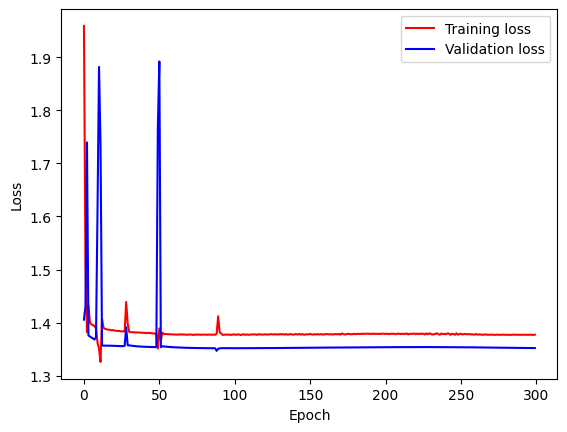

In [23]:
plt.plot(history.history['loss'], 'r', label='Training loss')
plt.plot(history.history['val_loss'], 'b', label='Validation loss')
plt.xlabel('Epoch')  # x轴变量名称  
plt.ylabel('Loss')  # y轴变量名称  
plt.legend()  # 画出曲线图标  

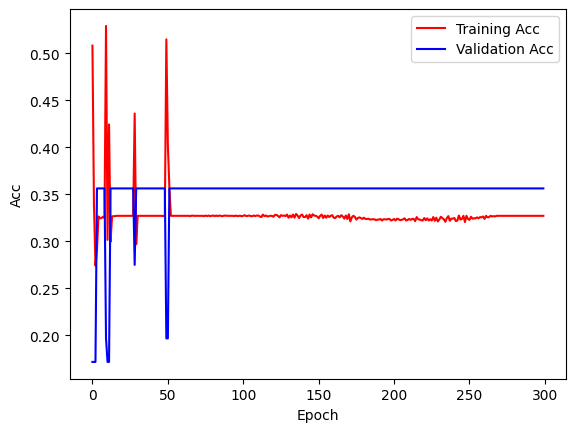

In [24]:
plt.plot(history.history['acc'], 'r', label='Training Acc')
plt.plot(history.history['val_acc'], 'b', label='Validation Acc')
plt.xlabel('Epoch')  # x轴变量名称  
plt.ylabel('Acc')  # y轴变量名称  
plt.legend()  # 画出曲线图标  

In [25]:
covn_base.trainable = True

# fine_tune_at = -10

# for layer in covn_base.layers[:fine_tune_at]:
#     layers.trainable = False

# 一定要以更低的学习速率
model.compile( loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005/10),
              metrics=['acc']
             )
initial_epochs = 300       #已经训练的epoch
fine_tune_epochs = 300    #继续训练的epoch
total_epochs = initial_epochs + fine_tune_epochs

In [26]:
history = model.fit(
    train_image_ds,
    steps_per_epoch = train_count//BATCH_SIZE,
    epochs=total_epochs,
    initial_epoch=initial_epochs,
    validation_data=test_image_ds,
    validation_steps=test_count//BATCH_SIZE
)

Epoch 301/600
94/94 [==============================] - 27s 181ms/step - loss: 1.3594 - acc: 0.3501 - val_loss: 1.3519 - val_acc: 0.3562
Epoch 302/600
94/94 [==============================] - 16s 170ms/step - loss: 1.3708 - acc: 0.3238 - val_loss: 1.3521 - val_acc: 0.3562
Epoch 303/600
94/94 [==============================] - 16s 170ms/step - loss: 1.3367 - acc: 0.3211 - val_loss: 1.3517 - val_acc: 0.3562
Epoch 304/600
94/94 [==============================] - 16s 170ms/step - loss: 1.3652 - acc: 0.3461 - val_loss: 1.3523 - val_acc: 0.3562
Epoch 305/600
94/94 [==============================] - 16s 170ms/step - loss: 1.3711 - acc: 0.3281 - val_loss: 1.3523 - val_acc: 0.3562
Epoch 306/600
94/94 [==============================] - 16s 170ms/step - loss: 1.3721 - acc: 0.3231 - val_loss: 1.3489 - val_acc: 0.3562
Epoch 307/600
94/94 [==============================] - 16s 171ms/step - loss: 1.3256 - acc: 0.3956 - val_loss: 1.3938 - val_acc: 0.2750
Epoch 308/600
94/94 [===========================

94/94 [==============================] - 16s 170ms/step - loss: 1.3699 - acc: 0.3271 - val_loss: 1.3520 - val_acc: 0.3562
Epoch 362/600
94/94 [==============================] - 16s 169ms/step - loss: 1.3697 - acc: 0.3271 - val_loss: 1.3520 - val_acc: 0.3562
Epoch 363/600
94/94 [==============================] - 16s 169ms/step - loss: 1.3698 - acc: 0.3271 - val_loss: 1.3520 - val_acc: 0.3562
Epoch 364/600
94/94 [==============================] - 16s 169ms/step - loss: 1.3698 - acc: 0.3271 - val_loss: 1.3520 - val_acc: 0.3562
Epoch 365/600
94/94 [==============================] - 16s 170ms/step - loss: 1.3697 - acc: 0.3271 - val_loss: 1.3520 - val_acc: 0.3562
Epoch 366/600
94/94 [==============================] - 16s 170ms/step - loss: 1.3698 - acc: 0.3271 - val_loss: 1.3520 - val_acc: 0.3562
Epoch 367/600
94/94 [==============================] - 16s 170ms/step - loss: 1.3699 - acc: 0.3271 - val_loss: 1.3520 - val_acc: 0.3562
Epoch 368/600
94/94 [==============================] - 16s 170

94/94 [==============================] - 16s 170ms/step - loss: 1.3700 - acc: 0.3285 - val_loss: 1.3523 - val_acc: 0.3562
Epoch 422/600
94/94 [==============================] - 16s 170ms/step - loss: 1.3706 - acc: 0.3258 - val_loss: 1.3523 - val_acc: 0.3562
Epoch 423/600
94/94 [==============================] - 16s 169ms/step - loss: 1.3704 - acc: 0.3268 - val_loss: 1.3523 - val_acc: 0.3562
Epoch 424/600
94/94 [==============================] - 16s 169ms/step - loss: 1.3704 - acc: 0.3271 - val_loss: 1.3523 - val_acc: 0.3562
Epoch 425/600
94/94 [==============================] - 16s 169ms/step - loss: 1.3701 - acc: 0.3281 - val_loss: 1.3523 - val_acc: 0.3562
Epoch 426/600
94/94 [==============================] - 16s 170ms/step - loss: 1.3705 - acc: 0.3268 - val_loss: 1.3523 - val_acc: 0.3562
Epoch 427/600
94/94 [==============================] - 16s 169ms/step - loss: 1.3710 - acc: 0.3248 - val_loss: 1.3523 - val_acc: 0.3562
Epoch 428/600
94/94 [==============================] - 16s 169

94/94 [==============================] - 16s 169ms/step - loss: 1.3715 - acc: 0.3235 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 482/600
94/94 [==============================] - 16s 169ms/step - loss: 1.3714 - acc: 0.3231 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 483/600
94/94 [==============================] - 16s 169ms/step - loss: 1.3712 - acc: 0.3241 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 484/600
94/94 [==============================] - 16s 169ms/step - loss: 1.3715 - acc: 0.3228 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 485/600
94/94 [==============================] - 16s 169ms/step - loss: 1.3711 - acc: 0.3241 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 486/600
94/94 [==============================] - 16s 169ms/step - loss: 1.3712 - acc: 0.3238 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 487/600
94/94 [==============================] - 16s 169ms/step - loss: 1.3714 - acc: 0.3231 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 488/600
94/94 [==============================] - 16s 169

94/94 [==============================] - 16s 169ms/step - loss: 1.3711 - acc: 0.3238 - val_loss: 1.3525 - val_acc: 0.3562
Epoch 542/600
94/94 [==============================] - 16s 169ms/step - loss: 1.3705 - acc: 0.3251 - val_loss: 1.3525 - val_acc: 0.3562
Epoch 543/600
94/94 [==============================] - 16s 169ms/step - loss: 1.3711 - acc: 0.3238 - val_loss: 1.3525 - val_acc: 0.3562
Epoch 544/600
94/94 [==============================] - 16s 169ms/step - loss: 1.3709 - acc: 0.3245 - val_loss: 1.3525 - val_acc: 0.3562
Epoch 545/600
94/94 [==============================] - 16s 169ms/step - loss: 1.3716 - acc: 0.3228 - val_loss: 1.3525 - val_acc: 0.3562
Epoch 546/600
94/94 [==============================] - 16s 169ms/step - loss: 1.3710 - acc: 0.3241 - val_loss: 1.3525 - val_acc: 0.3562
Epoch 547/600
94/94 [==============================] - 16s 169ms/step - loss: 1.3705 - acc: 0.3251 - val_loss: 1.3525 - val_acc: 0.3562
Epoch 548/600
94/94 [==============================] - 16s 169

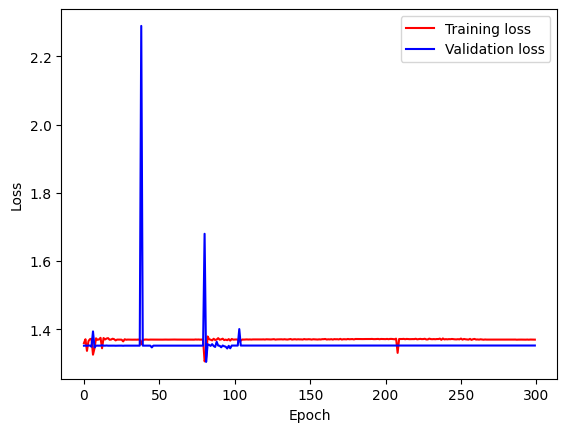

In [27]:
plt.plot(history.history['loss'], 'r', label='Training loss')
plt.plot(history.history['val_loss'], 'b', label='Validation loss')
plt.xlabel('Epoch')  # x轴变量名称  
plt.ylabel('Loss')  # y轴变量名称  
plt.legend()  # 画出曲线图标  

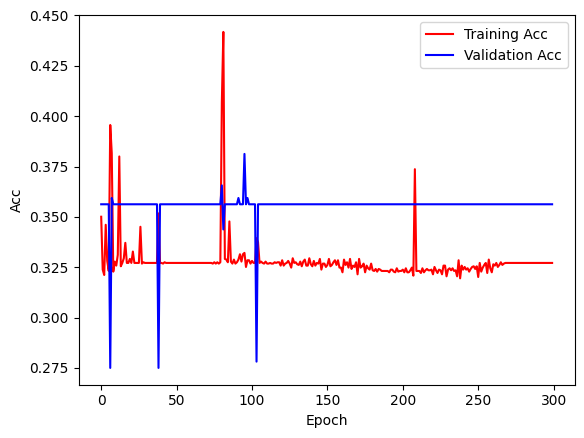

In [28]:
plt.plot(history.history['acc'], 'r', label='Training Acc')
plt.plot(history.history['val_acc'], 'b', label='Validation Acc')
plt.xlabel('Epoch')  # x轴变量名称  
plt.ylabel('Acc')  # y轴变量名称  
plt.legend()  # 画出曲线图标  

In [29]:
model.save('mdeol_chenceng1206v1.h5')

D:\anaconda3\envs\TxrTensorFlow\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [30]:
covn_base.trainable = True

fine_tune_at = -10

for layer in covn_base.layers[:fine_tune_at]:
    layers.trainable = False

# 一定要以更低的学习速率
model.compile( loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001/10),
              metrics=['acc']
             )
initial_epochs = 600       #已经训练的epoch
fine_tune_epochs = 300    #继续训练的epoch
total_epochs = initial_epochs + fine_tune_epochs

In [31]:
history = model.fit(
    train_image_ds,
    steps_per_epoch = train_count//BATCH_SIZE,
    epochs=total_epochs,
    initial_epoch=initial_epochs,
    validation_data=test_image_ds,
    validation_steps=test_count//BATCH_SIZE
)

Epoch 601/900
94/94 [==============================] - 25s 181ms/step - loss: 1.3585 - acc: 0.3511 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 602/900
94/94 [==============================] - 16s 169ms/step - loss: 1.3705 - acc: 0.3241 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 603/900
94/94 [==============================] - 16s 169ms/step - loss: 1.3700 - acc: 0.3255 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 604/900
94/94 [==============================] - 16s 168ms/step - loss: 1.3716 - acc: 0.3218 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 605/900
94/94 [==============================] - 16s 169ms/step - loss: 1.3692 - acc: 0.3271 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 606/900
94/94 [==============================] - 16s 169ms/step - loss: 1.3705 - acc: 0.3241 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 607/900
94/94 [==============================] - 16s 169ms/step - loss: 1.3693 - acc: 0.3271 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 608/900
94/94 [===========================

94/94 [==============================] - 16s 169ms/step - loss: 1.3692 - acc: 0.3271 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 662/900
94/94 [==============================] - 16s 168ms/step - loss: 1.3694 - acc: 0.3271 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 663/900
94/94 [==============================] - 16s 168ms/step - loss: 1.3692 - acc: 0.3271 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 664/900
94/94 [==============================] - 16s 169ms/step - loss: 1.3694 - acc: 0.3271 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 665/900
94/94 [==============================] - 16s 168ms/step - loss: 1.3693 - acc: 0.3271 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 666/900
94/94 [==============================] - 16s 168ms/step - loss: 1.3696 - acc: 0.3268 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 667/900
94/94 [==============================] - 16s 169ms/step - loss: 1.3693 - acc: 0.3275 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 668/900
94/94 [==============================] - 16s 169

94/94 [==============================] - 16s 168ms/step - loss: 1.3702 - acc: 0.3258 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 722/900
94/94 [==============================] - 16s 168ms/step - loss: 1.3696 - acc: 0.3278 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 723/900
94/94 [==============================] - 16s 168ms/step - loss: 1.3695 - acc: 0.3288 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 724/900
94/94 [==============================] - 16s 168ms/step - loss: 1.3704 - acc: 0.3251 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 725/900
94/94 [==============================] - 16s 168ms/step - loss: 1.3701 - acc: 0.3268 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 726/900
94/94 [==============================] - 16s 168ms/step - loss: 1.3696 - acc: 0.3281 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 727/900
94/94 [==============================] - 16s 168ms/step - loss: 1.3702 - acc: 0.3261 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 728/900
94/94 [==============================] - 16s 168

94/94 [==============================] - 16s 172ms/step - loss: 1.3705 - acc: 0.3251 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 782/900
94/94 [==============================] - 16s 172ms/step - loss: 1.3710 - acc: 0.3228 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 783/900
94/94 [==============================] - 16s 172ms/step - loss: 1.3706 - acc: 0.3248 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 784/900
94/94 [==============================] - 16s 172ms/step - loss: 1.3707 - acc: 0.3241 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 785/900
94/94 [==============================] - 16s 172ms/step - loss: 1.3706 - acc: 0.3241 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 786/900
94/94 [==============================] - 16s 172ms/step - loss: 1.3710 - acc: 0.3231 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 787/900
94/94 [==============================] - 16s 172ms/step - loss: 1.3710 - acc: 0.3231 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 788/900
94/94 [==============================] - 16s 172

94/94 [==============================] - 16s 173ms/step - loss: 1.3710 - acc: 0.3231 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 842/900
94/94 [==============================] - 16s 172ms/step - loss: 1.3698 - acc: 0.3258 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 843/900
94/94 [==============================] - 16s 172ms/step - loss: 1.3704 - acc: 0.3245 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 844/900
94/94 [==============================] - 16s 172ms/step - loss: 1.3713 - acc: 0.3225 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 845/900
94/94 [==============================] - 16s 172ms/step - loss: 1.3695 - acc: 0.3265 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 846/900
94/94 [==============================] - 16s 173ms/step - loss: 1.3712 - acc: 0.3228 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 847/900
94/94 [==============================] - 16s 172ms/step - loss: 1.3719 - acc: 0.3211 - val_loss: 1.3524 - val_acc: 0.3562
Epoch 848/900
94/94 [==============================] - 16s 172

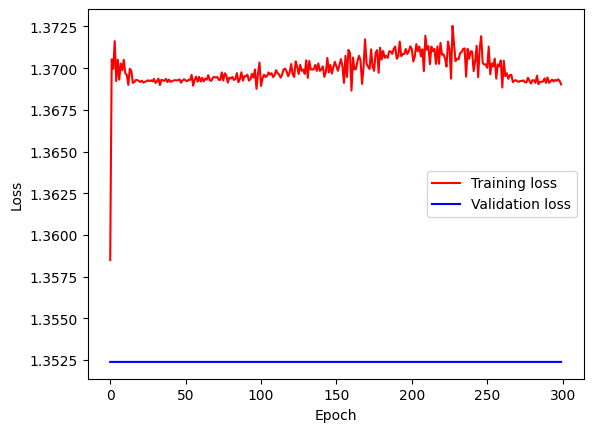

In [32]:
plt.plot(history.history['loss'], 'r', label='Training loss')
plt.plot(history.history['val_loss'], 'b', label='Validation loss')
plt.xlabel('Epoch')  # x轴变量名称  
plt.ylabel('Loss')  # y轴变量名称  
plt.legend()  # 画出曲线图标  

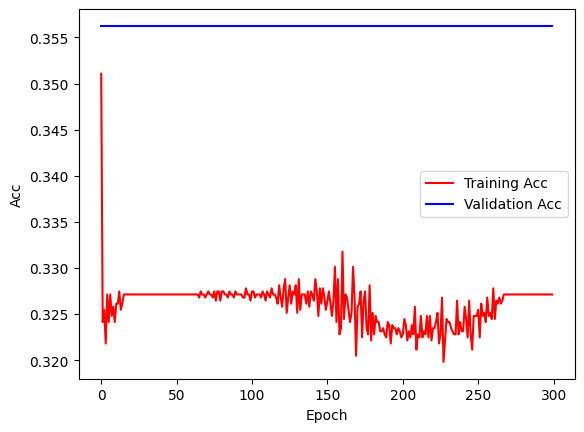

In [33]:
plt.plot(history.history['acc'], 'r', label='Training Acc')
plt.plot(history.history['val_acc'], 'b', label='Validation Acc')
plt.xlabel('Epoch')  # x轴变量名称  
plt.ylabel('Acc')  # y轴变量名称  
plt.legend()  # 画出曲线图标  

In [34]:
model.save('mdeol_chenceng12066v2.h5')

In [ ]:
covn_base.trainable = True

fine_tune_at = -5

for layer in covn_base.layers[:fine_tune_at]:
    layers.trainable = False

# 一定要以更低的学习速率
model.compile( loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001/20),
              metrics=['acc']
             )
initial_epochs = 320      #已经训练的epoch
fine_tune_epochs = 50    #继续训练的epoch
total_epochs = initial_epochs + fine_tune_epochs

In [ ]:
history = model.fit(
    train_image_ds,
    steps_per_epoch = train_count//BATCH_SIZE,
    epochs=total_epochs,
    initial_epoch=initial_epochs,
    validation_data=test_image_ds,
    validation_steps=test_count//BATCH_SIZE
)

In [ ]:
plt.plot(history.history['loss'], 'r', label='Training loss')
plt.plot(history.history['val_loss'], 'b', label='Validation loss')
plt.xlabel('Epoch')  # x轴变量名称  
plt.ylabel('Loss')  # y轴变量名称  
plt.legend()  # 画出曲线图标  

In [ ]:
plt.plot(history.history['acc'], 'r', label='Training Acc')
plt.plot(history.history['val_acc'], 'b', label='Validation Acc')
plt.xlabel('Epoch')  # x轴变量名称  
plt.ylabel('Acc')  # y轴变量名称  
plt.legend()  # 画出曲线图标  

In [ ]:
model.save('mdeol_chenceng0415v3.h5')

In [ ]:
covn_base.trainable = True

fine_tune_at = -5

for layer in covn_base.layers[:fine_tune_at]:
    layers.trainable = False

# 一定要以更低的学习速率
model.compile( loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001/40),
              metrics=['acc']
             )
initial_epochs = 370      #已经训练的epoch
fine_tune_epochs = 50    #继续训练的epoch
total_epochs = initial_epochs + fine_tune_epochs

In [ ]:
history = model.fit(
    train_image_ds,
    steps_per_epoch = train_count//BATCH_SIZE,
    epochs=total_epochs,
    initial_epoch=initial_epochs,
    validation_data=test_image_ds,
    validation_steps=test_count//BATCH_SIZE
)

In [ ]:
plt.plot(history.history['loss'], 'r', label='Training loss')
plt.plot(history.history['val_loss'], 'b', label='Validation loss')
plt.xlabel('Epoch')  # x轴变量名称  
plt.ylabel('Loss')  # y轴变量名称  
plt.legend()  # 画出曲线图标  

In [ ]:
plt.plot(history.history['acc'], 'r', label='Training Acc')
plt.plot(history.history['val_acc'], 'b', label='Validation Acc')
plt.xlabel('Epoch')  # x轴变量名称  
plt.ylabel('Acc')  # y轴变量名称  
plt.legend()  # 画出曲线图标  

In [ ]:
model.save('mdeol_chenceng0415v4.h5')

In [ ]:
new_model = tf.keras.models.load_model('mdeol_chenceng0415v4.h5')

In [ ]:
import time

In [ ]:
label_to_index = {'无缺陷': 0,'漏涂': 1,'流挂': 2,'堆积': 3}
index_to_label = dict((v, k) for k, v in label_to_index.items())

def judgement(img_path):
    start =time.perf_counter()
    img = load_predict_image(img_path)
    img = tf.expand_dims(img, axis=0)
    pred = new_model.predict(img)
    print(index_to_label.get(np.argmax(pred)))
    end = time.perf_counter()
    print('Running time: %s Seconds'%(end-start))

In [ ]:
start =time.perf_counter()
img_path = r'C:\Users\Administrator\Desktop\Workers\chenceng\gray_train\2liugua\12_2_8_12.jpg'
img = load_predict_image(img_path)
img = tf.expand_dims(img, axis=0)
pred = new_model.predict(img)
print(index_to_label.get(np.argmax(pred)))
end = time.perf_counter()
print('Running time: %s Seconds'%(end-start))

In [ ]:
judgement(r'C:\Users\Administrator\Desktop\Workers\chenceng\gray_train\2liugua\12_2_8_12.jpg')

In [ ]:
covn_base2 = tf.keras.applications.ResNet101V2(weights='imagenet', include_top=False, input_shape=(256,256,3))

In [ ]:
covn_base2.summary

In [ ]:
model = keras.Sequential()
model.add(covn_base2)  # 卷积基
model.add(layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(layers.Dense(1024,activation='relu'))     
model.add(tf.keras.layers.Dropout(0.5))
model.add(layers.Dense(256,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Dense(4,activation='softmax'))

In [ ]:
model.summary()